In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [2]:
import pandas as pd

In [3]:
import joblib
import glob
import genetools

In [4]:
import choosegpu
from malid import config
from malid.datamodels import GeneLocus

# do not use GPU - may be implicitly used by joblib imports of jax-unirep parameters?
choosegpu.configure_gpu(enable=False)

['-1']

In [5]:
def get_fold_data(output_dir):
    all_results = [
        joblib.load(f) for f in glob.glob(f"{output_dir}/loss.epoch.*.joblib")
    ]
    if len(all_results) == 0:
        # this was not run yet
        return None

    all_results_df = pd.DataFrame(all_results)
    # At this point each row's training_loss and holdout_loss are actually numpy arrays with single items. Weird
    # TODO: fix upstream.
    # Workaround: get single elements out
    all_results_df["training_loss"] = all_results_df["training_loss"].apply(
        lambda i: i.item()
    )
    all_results_df["holdout_loss"] = all_results_df["holdout_loss"].apply(
        lambda i: i.item()
    )
    return all_results_df.sort_values("epoch").reset_index(drop=True)

2022-12-25 16:18:23,607 - absl - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2022-12-25 16:18:27.329056: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-25 16:18:27,330 - absl - INFO - Unable to initialize backend 'cuda': FAILED_PRECONDITION: No visible GPU devices.
2022-12-25 16:18:27,334 - absl - INFO - Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Host CUDA Interpreter
2022-12-25 16:18:27,337 - absl - INFO - Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
2022-12-25 16:18:27,338 - absl - WARNING - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


GeneLocus.BCR fold 0:	best epoch is 20 out of 30 epochs.	Ready to stop.
GeneLocus.BCR fold 1:	best epoch is 17 out of 21 epochs.	Ready to stop.
GeneLocus.BCR fold 2:	best epoch is 19 out of 22 epochs.	Ready to stop.
GeneLocus.BCR fold -1:	best epoch is 19 out of 30 epochs.	Ready to stop.
GeneLocus.TCR fold 0:	best epoch is 19 out of 24 epochs.	Ready to stop.
GeneLocus.TCR fold 1:	best epoch is 19 out of 23 epochs.	Ready to stop.
GeneLocus.TCR fold 2:	best epoch is 19 out of 25 epochs.	Ready to stop.
GeneLocus.TCR fold -1:	best epoch is 22 out of 28 epochs.	Ready to stop.


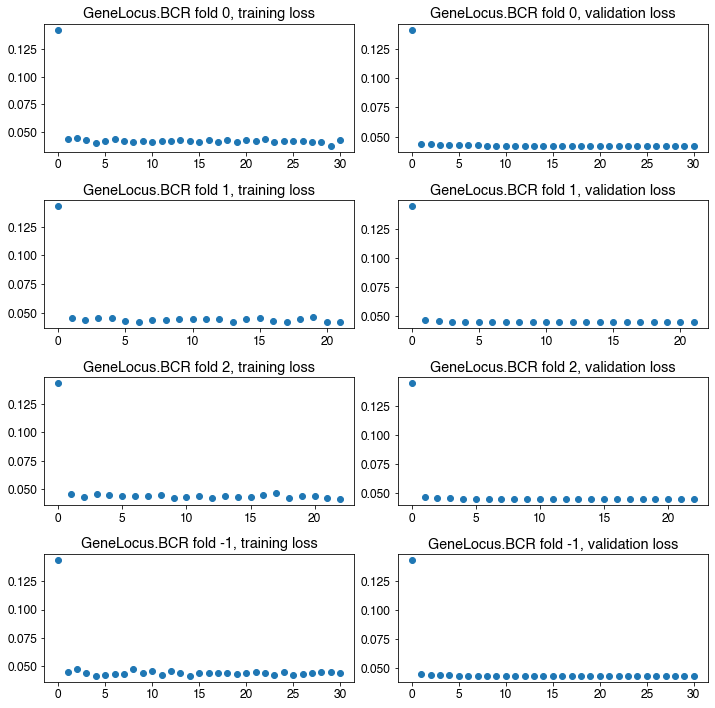

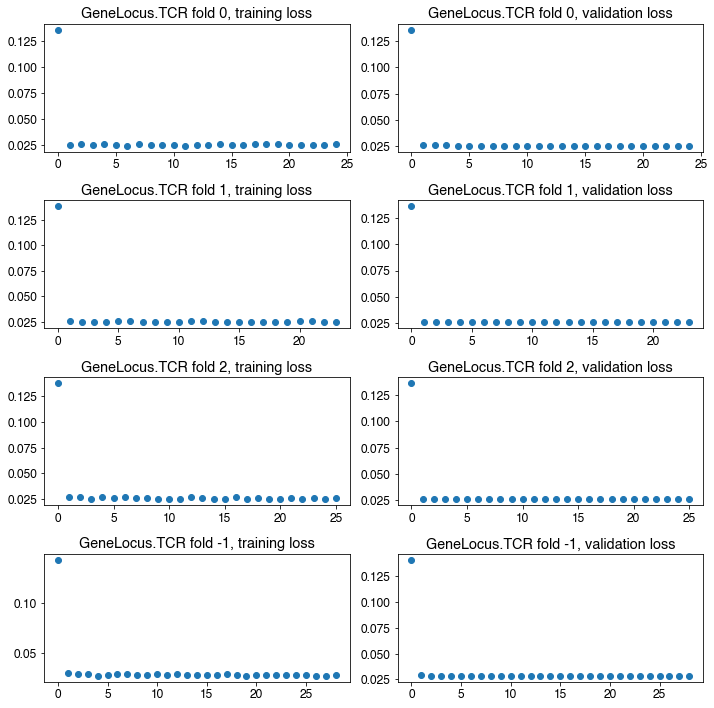

In [6]:
for gene_locus in config.gene_loci_used:
    GeneLocus.validate_single_value(gene_locus)
    fig, axarr = plt.subplots(nrows=len(config.all_fold_ids), ncols=2, figsize=(10, 10))
    for fold_id in config.all_fold_ids:
        all_results_df = get_fold_data(
            config.paths.fine_tuned_embedding_dir / gene_locus.name / f"fold_{fold_id}"
        )
        if all_results_df is None:
            print(f"Not yet run: gene_locus={gene_locus}, fold={fold_id}")
            continue

        axarr[fold_id, 0].scatter(
            all_results_df["epoch"], all_results_df["training_loss"]
        )
        axarr[fold_id, 0].set_title(f"{gene_locus} fold {fold_id}, training loss")

        axarr[fold_id, 1].scatter(
            all_results_df["epoch"], all_results_df["holdout_loss"]
        )
        axarr[fold_id, 1].set_title(f"{gene_locus} fold {fold_id}, validation loss")

        # Add early stopping - choose params from epoch with lowest validation loss, before overfitting
        # get best row
        best_results = all_results_df.iloc[all_results_df["holdout_loss"].idxmin()]
        best_epoch = best_results["epoch"]
        max_epoch = all_results_df["epoch"].max()
        ready_to_stop = max_epoch >= best_epoch + 2  # heuristic
        print(
            f"{gene_locus} fold {fold_id}:\tbest epoch is {best_epoch:n} out of {max_epoch:n} epochs.\t{'Ready to stop' if ready_to_stop else 'Keep running'}."
        )
        best_params = joblib.load(
            config.paths.fine_tuned_embedding_dir
            / gene_locus.name
            / f"fold_{fold_id}"
            / f"params.epoch.{best_epoch:n}.joblib"
        )

        # save out best params
        joblib.dump(
            best_params,
            config.paths.fine_tuned_embedding_dir
            / gene_locus.name
            / f"fold_{fold_id}"
            / "best_params.joblib",
        )
    fig.tight_layout()
    genetools.plots.savefig(
        fig, config.paths.output_dir / f"fine_tuning.loss.{gene_locus.name}.png"
    )